1. Импорт библиотек и настройка параметров

In [27]:
import geopandas as gpd
import numpy as np
import pulp
import folium
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.ops import unary_union

# --- Параметры ---
LAMP_RADIUS = 4       # Радиус освещения фонаря в метрах
CANDIDATE_STEP = 1    # Шаг для расстановки кандидатов вдоль дороги в метрах
DEMAND_POINT_STEP = 1 # Шаг для точек спроса (гарантия полного покрытия)

# Минимальное количество дополнительных проверок
MIN_EXTRA_CHECKS = 5

print("Библиотеки импортированы, все параметры заданы.")

Библиотеки импортированы, все параметры заданы.


2. Загрузка и подготовка данных

In [28]:
# Загружаем GeoJSON файл
gdf = gpd.read_file("malevich.geojson")

# Проецируем в метрическую систему (например, UTM)
if gdf.crs.is_geographic:
    gdf_proj = gdf.to_crs("EPSG:32637") # WGS 84 / UTM zone 37N
else:
    gdf_proj = gdf

# --- Обновленная логика: объединяем геометрии ---
roads_all = gdf_proj[gdf_proj.geometry.geom_type == 'LineString']
buildings_all = gdf_proj[gdf_proj.geometry.geom_type == 'Polygon']

# Объединяем все дороги в единый MultiLineString
roads_union = unary_union(roads_all.geometry)
# Объединяем все дома в единый MultiPolygon
buildings_union = unary_union(buildings_all.geometry)

print(f"Данные загружены. Дороги и дома объединены в единые объекты.")

Данные загружены. Дороги и дома объединены в единые объекты.


3. Генерация кандидатов и точек спроса

In [29]:
# --- Генерация кандидатов на установку фонарей (вдоль объединенной сети) ---
candidate_points = []
# unary_union может вернуть LineString или MultiLineString
if roads_union.geom_type == 'MultiLineString':
    for line in roads_union.geoms:
        for distance in np.arange(0, line.length, CANDIDATE_STEP):
            candidate_points.append(line.interpolate(distance))
else: # Если это один LineString
    for distance in np.arange(0, roads_union.length, CANDIDATE_STEP):
        candidate_points.append(roads_union.interpolate(distance))

candidate_gdf = gpd.GeoDataFrame(geometry=candidate_points, crs=gdf_proj.crs)
print(f"Сгенерировано {len(candidate_gdf)} кандидатов на установку фонарей.")


# --- Генерация точек спроса (для гарантии полного покрытия) ---
demand_points = []
if roads_union.geom_type == 'MultiLineString':
    for line in roads_union.geoms:
        for distance in np.arange(0, line.length, DEMAND_POINT_STEP):
            demand_points.append(line.interpolate(distance))
else:
    for distance in np.arange(0, roads_union.length, DEMAND_POINT_STEP):
        demand_points.append(roads_union.interpolate(distance))

demand_gdf = gpd.GeoDataFrame(geometry=demand_points, crs=gdf_proj.crs)
print(f"Сгенерировано {len(demand_gdf)} точек спроса, которые должны быть освещены.")

Сгенерировано 2998 кандидатов на установку фонарей.
Сгенерировано 2998 точек спроса, которые должны быть освещены.


4. Визуализация исходных данных

In [30]:
# Переводим все обратно в WGS84 для Folium
gdf_wgs84 = gdf_proj.to_crs("EPSG:4326")
candidate_wgs84 = candidate_gdf.to_crs("EPSG:4326")
demand_wgs84 = demand_gdf.to_crs("EPSG:4326")

# Находим центр карты
map_center = [gdf_wgs84.unary_union.centroid.y, gdf_wgs84.unary_union.centroid.x]
m = folium.Map(location=map_center, zoom_start=16)

# Стили для наглядности
folium.GeoJson(gdf_wgs84[gdf_wgs84.geometry.geom_type == 'Polygon'], name='Дома', style_function=lambda x: {'fillColor': 'grey', 'color': 'black', 'weight': 1}).add_to(m)
folium.GeoJson(gdf_wgs84[gdf_wgs84.geometry.geom_type == 'LineString'], name='Дороги', style_function=lambda x: {'color': 'blue', 'weight': 5, 'opacity': 0.8}).add_to(m)

# Точки спроса (маленькие, чтобы не загромождать карту)
for pt in demand_wgs84.geometry:
    folium.CircleMarker(location=(pt.y, pt.x), radius=1, color='green', fill_color='green', popup="Точка спроса").add_to(m)
    
# Кандидаты (чуть побольше и другого цвета)
for pt in candidate_wgs84.geometry:
    folium.CircleMarker(location=(pt.y, pt.x), radius=1, color='red', fill_color='red', popup="Кандидат").add_to(m)

folium.LayerControl().add_to(m)

# Отображаем карту прямо в выводе ячейки
m

C:\Users\anna.HOME-PC\AppData\Local\Temp\ipykernel_19268\156839790.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  map_center = [gdf_wgs84.unary_union.centroid.y, gdf_wgs84.unary_union.centroid.x]


5. Первая оптимизация: Минимизация количества фонарей

In [31]:
# Определяем, какие ТОЧКИ СПРОСА покрывает каждый кандидат
lamp_coverage = []
for lamp_candidate in candidate_gdf.geometry:
    coverage = []
    lamp_circle = lamp_candidate.buffer(LAMP_RADIUS)
    # Быстрая проверка с помощью пространственного индекса
    possible_matches_indices = demand_gdf.sindex.query(lamp_circle, predicate='intersects')
    possible_matches = demand_gdf.iloc[possible_matches_indices]
    precise_matches = possible_matches[possible_matches.intersects(lamp_circle)]
    
    lamp_coverage.append(list(precise_matches.index))

# Создаем задачу оптимизации
prob_min_lamps = pulp.LpProblem("Minimize_Lamps_Problem", pulp.LpMinimize)
lamp_vars = pulp.LpVariable.dicts("Lamp", range(len(candidate_gdf)), cat='Binary')

# Целевая функция: минимизировать количество фонарей
prob_min_lamps += pulp.lpSum(lamp_vars)

# Ограничения: каждая ТОЧКА СПРОСА должна быть покрыта
for i in range(len(demand_gdf)):
    prob_min_lamps += pulp.lpSum([lamp_vars[j] for j, coverage in enumerate(lamp_coverage) if i in coverage]) >= 1

# Решаем задачу
prob_min_lamps.solve(pulp.PULP_CBC_CMD(msg=0)) # msg=0 отключает лишние логи
print(f"Статус решения (минимальное количество): {pulp.LpStatus[prob_min_lamps.status]}")

min_lamp_count = int(pulp.value(prob_min_lamps.objective))
print(f"Минимально необходимое количество фонарей для полного покрытия: {min_lamp_count}")

Статус решения (минимальное количество): Optimal
Минимально необходимое количество фонарей для полного покрытия: 399


6. Расчет светового загрязнения (по периметру)

In [32]:
# --- Расчет светового загрязнения (длина засветки контуров зданий) ---
light_pollution_values = []
building_boundaries = buildings_union.boundary # Получаем контуры зданий (LineString)

for lamp_candidate in candidate_gdf.geometry:
    lamp_circle = lamp_candidate.buffer(LAMP_RADIUS)
    # Загрязнение - это ДЛИНА пересечения света с КОНТУРАМИ домов
    intersection_line = lamp_circle.intersection(building_boundaries)
    light_pollution_values.append(intersection_line.length)

# Добавляем в наш GeoDataFrame только один столбец с загрязнением
candidate_gdf['pollution'] = light_pollution_values

print("Расчет светового загрязнения для каждого кандидата завершен.")

Расчет светового загрязнения для каждого кандидата завершен.


7. Итеративная минимизация светового загрязнения

In [33]:
# --- Итеративная минимизация с новой логикой ---

best_solution = None
best_pollution = float('inf')
best_n_lamps = 0

# Для графика
history = []

n_lamps = min_lamp_count
iteration_count = 0

while True:
    # Условие выхода: выполнили минимальное число проверок И загрязнение начало расти
    # Добавляем допуск 1e-5 для сравнения чисел с плавающей запятой
    if iteration_count > MIN_EXTRA_CHECKS and len(history) > 1 and history[-1][1] > (history[-2][1] - 1e-5):
        print(f"\nЗагрязнение перестало уменьшаться после {iteration_count} итераций. Остановка.")
        break
        
    print(f"\n--- Попытка оптимизации с {n_lamps} фонарями (Итерация {iteration_count + 1}) ---")

    prob_pollution = pulp.LpProblem(f"Minimize_Pollution_{n_lamps}_Lamps", pulp.LpMinimize)
    lamp_vars_pollution = pulp.LpVariable.dicts("LampPollution", range(len(candidate_gdf)), cat='Binary')

    # Целевая функция: минимизировать световое загрязнение (по длине засветки)
    prob_pollution += pulp.lpSum([lamp_vars_pollution[i] * candidate_gdf['pollution'][i] for i in range(len(candidate_gdf))])

    # Ограничения
    prob_pollution += pulp.lpSum(lamp_vars_pollution) == n_lamps
    for i in range(len(demand_gdf)):
        prob_pollution += pulp.lpSum([lamp_vars_pollution[j] for j, coverage in enumerate(lamp_coverage) if i in coverage]) >= 1

    prob_pollution.solve(pulp.PULP_CBC_CMD(msg=0))

    if prob_pollution.status == pulp.LpStatusOptimal:
        current_pollution = pulp.value(prob_pollution.objective)
        history.append((n_lamps, current_pollution))
        print(f"Решение найдено. Световое загрязнение (длина): {current_pollution:.2f} м")

        # Сохраняем лучшее из всех найденных решений
        if current_pollution < best_pollution:
            best_pollution = current_pollution
            best_n_lamps = n_lamps
            selected_indices = [i for i in range(len(candidate_gdf)) if lamp_vars_pollution[i].varValue == 1]
            best_solution = candidate_gdf.iloc[selected_indices]
            print(f"!!! Найдено новое лучшее решение с {n_lamps} фонарями !!!")

        n_lamps += 1
        iteration_count += 1
    else:
        print(f"Не удалось найти оптимальное решение для {n_lamps} фонарей. Прерывание цикла.")
        break


--- Попытка оптимизации с 399 фонарями (Итерация 1) ---
Решение найдено. Световое загрязнение (длина): 93.72 м
!!! Найдено новое лучшее решение с 399 фонарями !!!

--- Попытка оптимизации с 400 фонарями (Итерация 2) ---
Решение найдено. Световое загрязнение (длина): 93.40 м
!!! Найдено новое лучшее решение с 400 фонарями !!!

--- Попытка оптимизации с 401 фонарями (Итерация 3) ---
Решение найдено. Световое загрязнение (длина): 93.20 м
!!! Найдено новое лучшее решение с 401 фонарями !!!

--- Попытка оптимизации с 402 фонарями (Итерация 4) ---
Решение найдено. Световое загрязнение (длина): 93.20 м

--- Попытка оптимизации с 403 фонарями (Итерация 5) ---
Решение найдено. Световое загрязнение (длина): 93.20 м

--- Попытка оптимизации с 404 фонарями (Итерация 6) ---
Решение найдено. Световое загрязнение (длина): 93.20 м

Загрязнение перестало уменьшаться после 6 итераций. Остановка.


8. Финальная визуализация

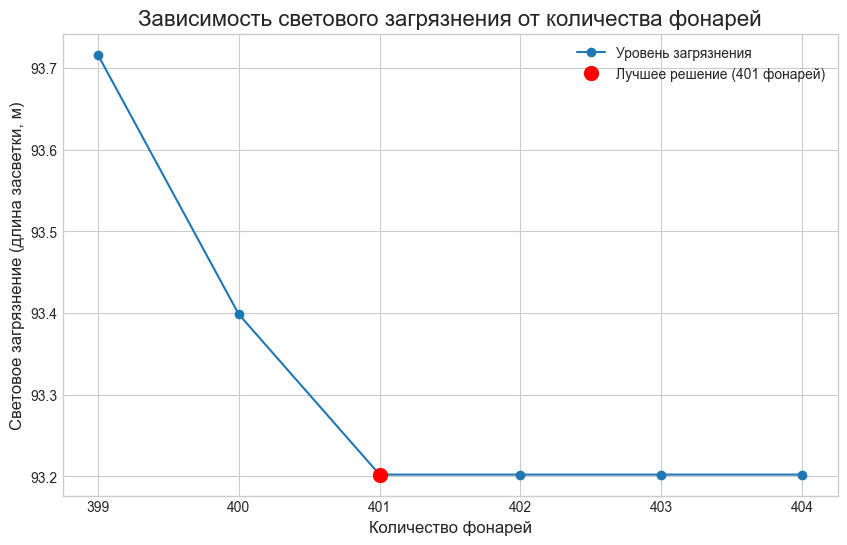

C:\Users\anna.HOME-PC\AppData\Local\Temp\ipykernel_19268\1168455720.py:26: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  final_map_center = [final_solution_wgs84.unary_union.centroid.y, final_solution_wgs84.unary_union.centroid.x]



Финальная конфигурация для 401 фонарей:
Итоговое световое загрязнение: 93.20 м


: 

In [ ]:
# --- Построение графика ---
if history:
    lamp_counts = [item[0] for item in history]
    pollution_values = [item[1] for item in history]
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(lamp_counts, pollution_values, marker='o', linestyle='-', label='Уровень загрязнения')
    ax.plot(best_n_lamps, best_pollution, 'ro', markersize=10, label=f'Лучшее решение ({best_n_lamps} фонарей)')
    
    ax.set_title('Зависимость светового загрязнения от количества фонарей', fontsize=16)
    ax.set_xlabel('Количество фонарей', fontsize=12)
    ax.set_ylabel('Световое загрязнение (длина засветки, м)', fontsize=12)
    ax.legend()
    ax.grid(True)
    # Делаем отметки на оси X целочисленными
    if len(lamp_counts) > 1:
        plt.xticks(np.arange(min(lamp_counts), max(lamp_counts)+1, 1))
    plt.show()

# --- Финальная карта ---
if best_solution is not None:
    final_solution_wgs84 = best_solution.to_crs("EPSG:4326")
    
    final_map_center = [final_solution_wgs84.unary_union.centroid.y, final_solution_wgs84.unary_union.centroid.x]
    final_map = folium.Map(location=final_map_center, zoom_start=16)

    folium.GeoJson(gdf_wgs84[gdf_wgs84.geometry.geom_type == 'Polygon'], name='Дома', style_function=lambda x: {'fillColor': 'grey', 'color': 'black', 'weight': 1}).add_to(final_map)
    folium.GeoJson(gdf_wgs84[gdf_wgs84.geometry.geom_type == 'LineString'], name='Дороги', style_function=lambda x: {'color': 'black', 'weight': 3, 'opacity': 0.7}).add_to(final_map)

    for idx, row in final_solution_wgs84.iterrows():
        center = (row.geometry.y, row.geometry.x)
        folium.Circle(
            location=center,
            radius=LAMP_RADIUS,
            color='yellow',
            fill=True,
            fill_color='yellow',
            fill_opacity=0.3,
            tooltip=f"Загрязнение от этого фонаря: {best_solution.loc[idx, 'pollution']:.2f} м"
        ).add_to(final_map)
        folium.CircleMarker(
            location=center,
            radius=3,
            color='orange',
            fill=True,
            fill_color='red'
        ).add_to(final_map)
    
    final_map.fit_bounds(final_map.get_bounds())
    folium.LayerControl().add_to(final_map)

    print(f"\nФинальная конфигурация для {len(best_solution)} фонарей:")
    print(f"Итоговое световое загрязнение: {best_pollution:.2f} м")
    
    # Отображаем карту в выводе
    final_map
else:
    print("\nНе удалось найти финальное решение.")
final_map.save('result_map.html')